# Exploratory Data Analysis

- 데이터 전처리
    - 데이터 탐색
    - 데이터 클렌징

In [176]:
%matplotlib inline
pd.options.display.max_columns = 200
from numpy.linalg import svd
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

In [2]:
df_action = pd.read_csv('../input/제6회 L.POINT Big Data Competition-분석용데이터-01.온라인 행동 정보.csv')
df_transaction = pd.read_csv('../input/제6회 L.POINT Big Data Competition-분석용데이터-02.거래 정보.csv')
df_client_demo = pd.read_csv('../input/제6회 L.POINT Big Data Competition-분석용데이터-03.고객 Demographic 정보.csv')
df_product = pd.read_csv('../input/제6회 L.POINT Big Data Competition-분석용데이터-04.상품분류 정보.csv')

# Online Action columns
- clnt_id : 클라이언트 ID, 고객을 고유하게 식별할 수 있도록 랜덤으로 부여된 ID
- sess_id : 세션 ID, Web/App에 접속 후 세션이 시작될 때 부여된 순번 ID (클라이언트 ID에 여러개의 세션 ID 발급될 수 있음)
- hit_seq : 조회일련번호, 조회 순서를 알 수 있도록 부여된 일련번호
- action_type : 행동유형, 총 8가지의 행동 유형을 구분한 코드 [0.검색/ 1.제품 목록/ 2.제품 세부정보 보기/ 3. 장바구니 제품 추가/ 4, 장바구니 제품 삭제/ 5. 결제시도/ 6. 구매 완료/ 7. 구매환불/ 8. 결제옵션]
- biz_unit : 업종단위, 온라인 및 오프라인 이용처를 구분하는 단위코드
- sess_dt : 세션일자, (YYYYMMDD 형식)
- hit_tm : 조회시간 (HH:MM 형식)
- hit_pss_tm : 조회경과시간, 세션이 시작된 이후 해당 조회까지 경과한 시간(단위:밀리초), 첫번째 조회하면 0으로 설정
- trans_id : 거래 ID, 구매내역을 고유하게 식별할 수 있도록 랜덤으로 부여된 ID
- srch_kwd : 검색 키워드, 고객이 검색한 키워드
- tot_pag_view_ct : 홈페이지조회건수, 세션 내의 총 페이지(화면)뷰 수
- tot_sess_hr_v : 총세션시간값, 세션 내 총 시간(단위: 초)
- trfc_src : 유입채널, 고객이 유입된 채널, [DIRECT/ PUSH/ WEBSITE/ PORTAL_1/ PORTAL_2/ PORTAL_3/ unknown]
- dvc_ctg_nm : 기기유형, [mobile_web/ mobile_app/ PC]

In [3]:
df_action.tail(10)

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm
3196352,31032,3,5,0,A02,20190805,10:54,47963,NaN,오야니,8.0,356.0,unknown,mobile_app
3196353,31032,2,6,0,A02,20190804,22:37,527684,NaN,오야니,19.0,1047.0,unknown,mobile_app
3196354,31032,2,9,0,A02,20190804,22:41,771472,NaN,오야니,19.0,1047.0,unknown,mobile_app
3196355,31032,2,1,0,A02,20190804,22:35,356864,NaN,양가죽자켓,19.0,1047.0,unknown,mobile_app
3196356,31032,3,1,0,A02,20190805,10:53,8782,NaN,오야니,8.0,356.0,unknown,mobile_app
3196357,31040,1,1,0,A02,20190815,03:47,13525,NaN,다이슨 에어랩,4.0,62.0,unknown,mobile_web
3196358,4129,1,2,0,A02,20190721,01:22,250099,NaN,여성메탈시계,3.0,250.0,unknown,mobile_web
3196359,4129,1,1,0,A02,20190721,01:18,1525,NaN,여성메탈시계,3.0,250.0,unknown,mobile_web
3196360,54403,3,1,0,A02,20190731,20:14,16905,NaN,비비고왕교자,3.0,68.0,unknown,mobile_app
3196361,54403,4,1,0,A02,20190818,16:35,82700,NaN,에포테쉬볼륨팝브러쉬,5.0,101.0,unknown,mobile_app


### Missing Data

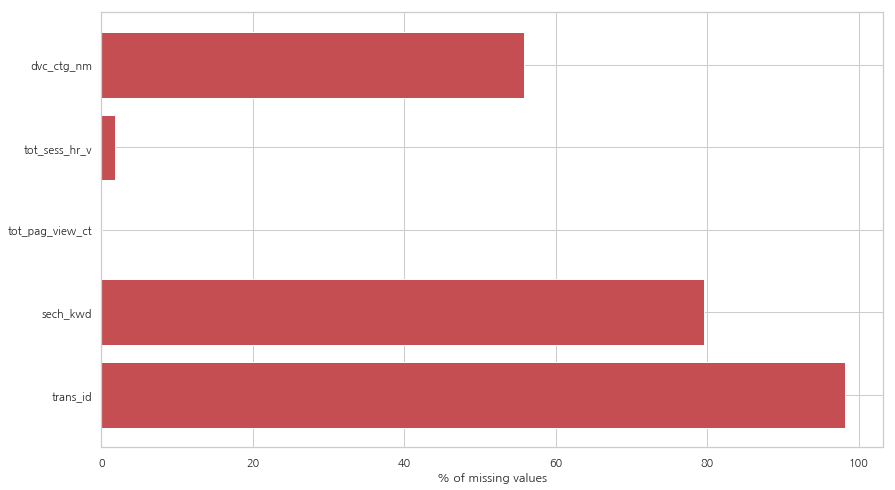

In [4]:
df_missing = df_action.isnull().sum(axis=0).reset_index()
df_missing.columns = ['column_name', 'missing_count']
df_missing = df_missing.loc[df_missing['missing_count']>0]
ind = np.arange(df_missing.shape[0])
fig, ax = plt.subplots(figsize=(14,8))
rects = ax.barh(ind, (df_missing.missing_count.values/len(df_action))*100, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(df_missing.column_name.values, rotation='horizontal')
ax.set_xlabel("% of missing values")
plt.show()

# Transaction columns
- clnt_id : 클라이언트 ID 
- trans_id : 거래 ID
- trans_seq: 거래일련번호, 해당 거래 ID의 구매 내역 내 구매 순서를 알 수 있도록 부여된 일련번호
- biz_unit : 업종단위  
- pd_c : 상품소분류코드,
- de_dt : 상품을 구매한 일자 (YYYYMMDD)
- de_tm : 상품을 구매한 시각 (HH:MM)
- buy_am : 구매한 상품의 금액
- buy_ct : 구매한 상품의 수량

In [5]:
df_transaction.tail(10)

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct
599951,2400,4453,2,B03,0313,20190927,11:25,7700,1
599952,28484,13342,1,B03,1060,20190927,15:47,5000,1
599953,54080,2842,2,B03,0339,20190927,16:16,5200,1
599954,54080,2842,1,B03,1066,20190927,16:16,12600,1
599955,35311,2839,1,B03,0339,20190927,14:09,4500,1
599956,35311,2839,3,B03,0339,20190927,14:09,3500,1
599957,35311,2839,4,B03,0339,20190927,14:09,3600,2
599958,35311,2839,5,B03,0339,20190927,14:09,3500,1
599959,35311,2839,2,B03,0339,20190927,14:09,4500,1
599960,35311,2839,6,B03,0324,20190927,14:09,6800,1


### Missing Data

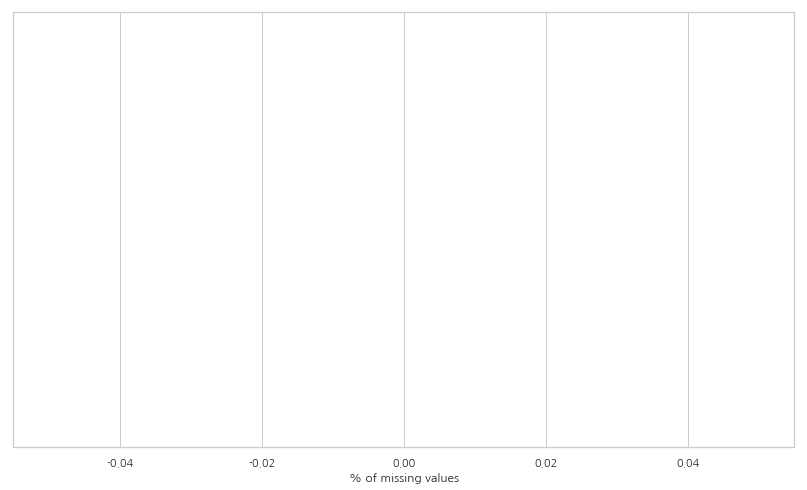

In [6]:
df_missing = df_transaction.isnull().sum(axis=0).reset_index()
df_missing.columns = ['column_name', 'missing_count']
df_missing = df_missing.loc[df_missing['missing_count']>0]
ind = np.arange(df_missing.shape[0])
fig, ax = plt.subplots(figsize=(14,8))
rects = ax.barh(ind, (df_missing.missing_count.values/len(df_transaction))*100, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(df_missing.column_name.values, rotation='horizontal')
ax.set_xlabel("% of missing values")
plt.show()

In [7]:
df1 = df_transaction[['clnt_id', 'pd_c']]
df1.tail(5)

,clnt_id,pd_c
599956,35311,0339
599957,35311,0339
599958,35311,0339
599959,35311,0339
599960,35311,0324


In [8]:
df1['pd_c'].unique()

array(['unknown', '0565', '0572', ..., '0689', '1078', '0305'],
      dtype=object)

In [9]:
df1.loc[df1['pd_c'] == 'unknown', 'pd_c'] = '0000'

In [10]:
df1['clnt_id'] = df1['clnt_id'].astype(int)
df1['pd_c'] = df1['pd_c'].astype(int)

# Client Demographic
- clnt_id : 클라이언트 ID
- clnt_gender : 성별 [M/F/unknown]
- clnt_age : 연령대 [10대 이하/ 20대/ 30대/ 40대/ 50대/ 60대 이상/ 정보없음 : unknown]

In [11]:
df_client_demo.tail(10)

,clnt_id,clnt_gender,clnt_age
72389,72420,unknown,unknown
72390,72421,unknown,unknown
72391,72422,unknown,unknown
72392,72423,F,30
72393,72424,M,40
72394,72425,unknown,unknown
72395,72426,unknown,unknown
72396,72427,unknown,unknown
72397,72428,unknown,unknown
72398,72429,unknown,unknown


### Missing Data

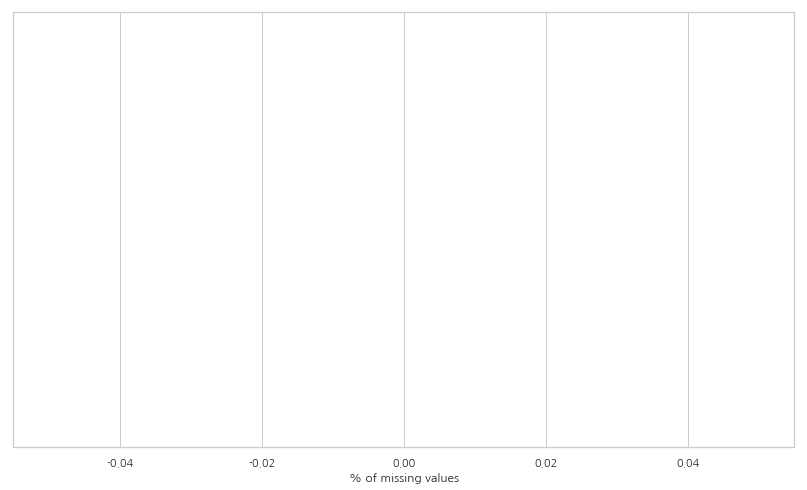

In [12]:
df_missing = df_client_demo.isnull().sum(axis=0).reset_index()
df_missing.columns = ['column_name', 'missing_count']
df_missing = df_missing.loc[df_missing['missing_count']>0]
ind = np.arange(df_missing.shape[0])
fig, ax = plt.subplots(figsize=(14,8))
rects = ax.barh(ind, (df_missing.missing_count.values/len(df_client_demo))*100, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(df_missing.column_name.values, rotation='horizontal')
ax.set_xlabel("% of missing values")
plt.show()

# Product columns
- pd_c : 상품 소분류코드 (최소단위)
- clac_nm1 : 상품 대분류명
- clac_nm2 : 상품 중분류명
- clac_nm3 : 상품 소분류명

In [13]:
df_product.tail(10)

,pd_c,clac_nm1,clac_nm2,clac_nm3
1657,1658,Women's Clothing,Women's Special Use Clothing,Other Women's Special Use Clothing
1658,1659,Women's Clothing,Women's Special Use Clothing,Women's Costumes
1659,1660,Women's Clothing,Women's Special Use Clothing,Women's Fashion Trainingwear
1660,1661,Women's Clothing,Women's Upper Bodywear / Tops,Women's Blouses
1661,1662,Women's Clothing,Women's Upper Bodywear / Tops,Women's Button-Down Shirts
1662,1663,Women's Clothing,Women's Upper Bodywear / Tops,Women's Cardigans
1663,1664,Women's Clothing,Women's Upper Bodywear / Tops,Women's Sweaters / Pullover
1664,1665,Women's Clothing,Women's Upper Bodywear / Tops,Women's Sweatshirts / Hoodies
1665,1666,Women's Clothing,Women's Upper Bodywear / Tops,Women's T-shirts / Tops
1666,1667,Women's Clothing,Women's Upper Bodywear / Tops,Women's Vests


### Missing Data

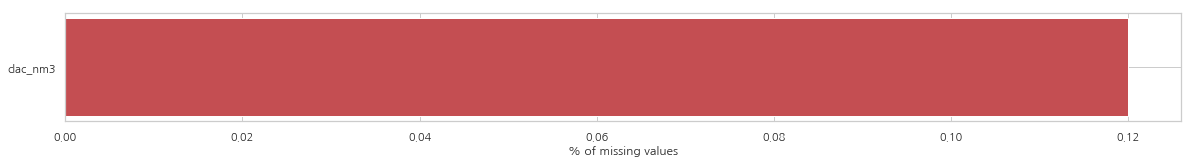

In [14]:
df_missing = df_product.isnull().sum(axis=0).reset_index()
df_missing.columns = ['column_name', 'missing_count']
df_missing = df_missing.loc[df_missing['missing_count']>0]
ind = np.arange(df_missing.shape[0])
fig, ax = plt.subplots(figsize=(20,2))
rects = ax.barh(ind, (df_missing.missing_count.values/len(df_product))*100, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(df_missing.column_name.values, rotation='horizontal')
ax.set_xlabel("% of missing values")
plt.show()

## EDA

In [15]:
import surprise

In [16]:
df = pd.merge(df1, df_product, how='left')
df.tail(5)

,clnt_id,pd_c,clac_nm1,clac_nm2,clac_nm3
599956,35311,339,Cosmetics / Beauty Care,Skin Care,Facial Masks
599957,35311,339,Cosmetics / Beauty Care,Skin Care,Facial Masks
599958,35311,339,Cosmetics / Beauty Care,Skin Care,Facial Masks
599959,35311,339,Cosmetics / Beauty Care,Skin Care,Facial Masks
599960,35311,324,Cosmetics / Beauty Care,Makeup,Nail Stickers / Stones


In [17]:
df2 = df[['clnt_id', 'clac_nm3']]
df2.tail(2)

,clnt_id,clac_nm3
599959,35311,Facial Masks
599960,35311,Nail Stickers / Stones


In [18]:
df3 = df2.groupby(["clnt_id", "clac_nm3"]).size().reset_index(name="Counts")
df3.tail(2)

,clnt_id,clac_nm3,Counts
327502,72424,Women's Running / Training Shoes,2
327503,72424,Wrapping Vegetables,1


In [19]:
df4 = df3.pivot_table('Counts', 'clnt_id', 'clac_nm3', fill_value=0)
df4.tail(5)

clac_nm3,,Accessory Bags,Accident Prevention Equipment,Adhesive Tapes,Adhesives,Adult's Bed Covers and Skirts,Adult's Diapers,Adult's Disposable Briefes,Adults' Bed Fillings,Adults' Bedding Sets,Adults' Blankets,Adults' Duvet / Duvet Cover,Adults' Korean Style Mattress / Covers,Adults' Matteress Pads,Adults' Mattress Cover,Adults' Pads / Bed Spread,Adults' Pillow / Pillow Cover,Aekjeot,Air Fresheners,Air Purifiers,Albums,All-In-One Underwear,Almonds,Altari Radishes,Amusement Facilities,Amusement Park Tickets,Anchovies Gift Sets,Anklets,Ant / Cockroach Killers,Apicultural Honey,Apples,Apples Gift Sets,Apricots,Aqua Shoes,Aquarium Bird Accessories,Aquarium Fish,Aquarium Fish Accessories,Aroma Therapy Diffusers,Art / Creative Toys,Artificial Flowers,Artificial Seasonings,Arts / Crafts,Assembly Toys,Assorted Mushrooms,Assorted Sashimi / Sliced Raw Fish,Atka Mackerel,Audio Accessories,Audio Amplifiers / Speakers,Australian Imported Beefs - Bone-in Short Ribs,Australian Imported Beefs - Briskets,Australian Imported Beefs - Chunks,Australian Imported Beefs - Hanging Tenders,Australian Imported Beefs - Outside Skirts,Australian Imported Beefs - Rounds,Australian Imported Beefs - Rumps,Australian Imported Beefs - Shanks,Australian Imported Beefs - Shoulders,Australian Imported Beefs - Sirloins,Australian Imported Beefs - Striploins,Australian Imported Beefs - Tenderloins,Automobile Oil / Additives,Avocados,BB / Face Foundation / Compact Powder,Baby Bath Products,Baby Bath Toys,Baby Beverages,Baby Bodysuits,Baby Bouncers / Saucers / Walkers,Baby Car Seats / Mattress Pads,Baby Carriers,Baby Foods Accessories,Baby Formula,Baby Ginsengs,Baby Health Supplements,Baby Mattress Pads,Baby Potties& Seats / Potty Trainings,Baby Shampoos / Body Washes,Baby Skin Care,Baby Snack Foods,Baby Strollers,Baby Wipes,Backpakcs,Bacons,Badminton Rackets,Badminton Shuttlecocks,Bag Sets,Bakery,Bakery Cakes,Bakery Gift Sets,Bakery Ingredients,Bakery Pastries,Bakery Plain breads,Bakewares,Balloons,Ballpoint Pens,Bananas,Band-Aids,Bar Ice Creams,Barley,Baseball Bats,...,Women's Blouses,Women's Boots,Women's Button-Down Shirts,Women's Cardigans,Women's Casual Sport Socks and Hosiery,Women's Climbing Bodysuits / Dresses,Women's Climbing Clothing Sets,Women's Climbing Jumpers / Jackets,Women's Climbing Paddingwear,Women's Climbing Pants,Women's Climbing T-shirts / Tops,Women's Climbing Vests,Women's Clutch Bags,Women's Coats,Women's Comport Shoes,Women's Costumes,Women's Cross-Body Bags,Women's Dresses,Women's Fashion Sneakers,Women's Fashion Trainingwear,Women's Flats,Women's Flip Flops,Women's Fur Coats,Women's General Socks and Hosiery,Women's General Sport Pants,Women's General Wallets,Women's Gloves,Women's Golf Bodysuits / Dresses,Women's Golf Clothing Sets,Women's Golf Knitwear / Cardigan,Women's Golf Pants,Women's Golf Skirts,Women's Golf T-shirts / Tops,Women's Gowns / Robes,Women's Hair Accessories,Women's Homewears,Women's Jackets,Women's Jeans,Women's Jumpers,Women's Jumpsuits / Overalls,Women's Leather Clothing,Women's Leggings,Women's Liner Socks,Women's Loafer,Women's Paddingwear,Women's Panties,Women's Pants,Women's Perfume Sets,Women's Perfumes,Women's Pumps,Women's Running / Training Shoes,Women's Sandals,Women's Shoes Accessories,Women's Shoulder Bags,Women's Skirts,Women's Sleepwear,Women's Slip-Ons,Women's Slippers,Women's Snow Shoes,Women's Socks and Hosiery Gift Sets,Women's Sport Jumpers / Jackets,Women's Sport Sandals / Slippers,Women's Sport Shoes Accessories,Women's Sport Sweatshirts / Hoodies,Women's Sport T-Shirts / Tops,Women's Sport Underwear,Women's Sunglasses,Women's Sweaters / Pullover,Women's Sweatshirts / Hoodies,Women's Swimwear,Women's T-shirts / Tops,Women's Thermal Underwear,Women's Tights,Women's Totes,Women's Trainingwear,Women's Trench Coats,Women's Undershirts & Camisoles,Women's Underwear Sets,Women's Vests,Women's Watches,Women's' Hipsacks,Work Gloves,Wrapping Vegetables,Writing Boards,Writing Correction Supplies,Writing

### Dataframe convert array 

In [55]:
A = df4.values
A.shape

(11270, 1662)

### SVD(Singure Value Decomposition) - Full_matrices
- U : N x N
- S : N x M
- VT : M x M

In [58]:
U, S, VT = svd(A, full_matrices=True)
U.shape, S.shape, VT.shape

((11270, 11270), (1662,), (1662, 1662))

### SVD(Singure Value Decomposition) - 축소형
- U : N x N
- S : M x M
- M : M x M

In [59]:
U2, S2, VT2 = svd(A, full_matrices=False)
U2.shape, S2.shape, VT2.shape

((11270, 1662), (1662,), (1662, 1662))

### Truncated SVD ; 
- S의 대각 성분은 특이치라고 하며 전체 특이치 중에서 가장 값이 큰 k개의 특이치만을 사용하여 계산한다. 
- $\hat U$ : M X k
- $\hat S$ : k X k
- $\hat V$ : k X N

In [68]:
A = A.astype(float)

- Scipy and Numpy both have functions to do the singular value decomposition. I’m going to use the Scipy function svds because it let’s me choose how many latent factors I want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [69]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(A, k=20)

In [70]:
U.shape, sigma.shape, Vt.shape

((11270, 20), (20,), (20, 1662))

In [84]:
#U[로우 관련된 인덱싱, 칼럼 관련된 인덱싱]
U[0]

array([ 0.00056103, -0.00361575,  0.01036407, -0.00033232,  0.00868462,
        0.00182422, -0.0025627 , -0.00576533, -0.00978039,  0.0006993 ,
        0.0033694 , -0.00029969,  0.00175002, -0.00113666,  0.00012532,
        0.0021272 , -0.00346927,  0.00191466, -0.00054182,  0.00135897])

# Creation of Sparse matrix(User x Item/MCAT)

In [133]:
df3.tail(2)

,clnt_id,clac_nm3,Counts
327502,72424,Women's Running / Training Shoes,2
327503,72424,Wrapping Vegetables,1


In [134]:
data = df3.copy()

In [135]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327504 entries, 0 to 327503
Data columns (total 3 columns):
clnt_id     327504 non-null int64
clac_nm3    327504 non-null object
Counts      327504 non-null int64
dtypes: int64(2), object(1)
memory usage: 7.5+ MB


In [136]:
# Create a numeric user_id and mcat_id column
data['user'] = data['clnt_id'].astype('category')
data['mcat'] = data['clac_nm3'].astype("category")
data['user_id'] = data['user'].cat.codes
data['mcat_id'] = data['mcat'].cat.codes

In [137]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327504 entries, 0 to 327503
Data columns (total 7 columns):
clnt_id     327504 non-null int64
clac_nm3    327504 non-null object
Counts      327504 non-null int64
user        327504 non-null category
mcat        327504 non-null category
user_id     327504 non-null int16
mcat_id     327504 non-null int16
dtypes: category(2), int16(2), int64(2), object(1)
memory usage: 10.5+ MB


In [138]:
data.drop(['clnt_id', 'clac_nm3'], axis=1, inplace=True)

In [139]:
data.tail(100)

,Counts,user,mcat,user_id,mcat_id
327404,1,72373,Functional Milk,11265,557
327405,1,72373,Hair dyes,11265,657
327406,1,72373,Home Ice Creams,11265,682
327407,1,72373,Kitchen Knives / Scissors,11265,814
327408,1,72373,Meats for Steak,11265,905
327409,1,72373,Men's Skin Care,11265,957
327410,1,72373,Others,11265,1163
327411,1,72373,Planners,11265,1232
327412,2,72373,Rags,11265,1271
327413,2,72373,Salads,11265,1305


In [140]:
# Create a lookup frame so we can get the mcat names back in
item_lookup = data[['mcat_id', 'mcat']].drop_duplicates()
item_lookup['mcat_id'] = item_lookup.mcat_id.astype(str)
item_lookup.tail(5)

,mcat_id,mcat
307309,878,MTB
308902,1118,Other Men's Outwear
313750,1019,Mushrooms for Medical Use
316220,1571,Women's Climbing Pants
320723,41,Arts / Crafts


In [143]:
user_lookup = data[['user_id', 'user']].drop_duplicates()
user_lookup['user_id'] = item_lookup.mcat_id.astype(str)
user_lookup.tail(4)

,user_id,user
327416,NaN,72400
327420,NaN,72410
327451,NaN,72423
327453,NaN,72424


In [144]:
data = data.drop(['user', 'mcat'], axis=1)
data.tail(5)

,Counts,user_id,mcat_id
327499,1,11269,1492
327500,2,11269,1499
327501,1,11269,1538
327502,2,11269,1612
327503,1,11269,1644


In [146]:
# Drop any rows that have 0 purchases
data = data.loc[data.Counts != 0]
data.tail(5)

,Counts,user_id,mcat_id
327499,1,11269,1492
327500,2,11269,1499
327501,1,11269,1538
327502,2,11269,1612
327503,1,11269,1644


In [147]:
# Create lists of all users, mcats and their purchase counts
users = list(np.sort(data.user_id.unique()))
mcats = list(np.sort(data.mcat_id.unique()))
purchases = list(data.Counts)

In [151]:
# Get the rows and columns for our new matrix
rows = data.user_id.astype(int)
cols = data.mcat_id.astype(int)

In [175]:
import scipy.sparse as sparse
# Create a sparse matrix for our users and mcats containing number of purchases
data_sparse_new = sparse.csr_matrix((purchases, (rows, cols)), shape=(len(users), len(mcats)))

## Calculation of User vectors and MCAT vectors

In [186]:
# lambda: Regularizer value
def implicit_als(sparse_data, alpha_val=40, iterations=10, lambda_val=0.1, features=10):
    # Calculate the Confidence for each value in our data
    confidence = sparse_data * alpha_val
    
    # Get the size of user rows and item columns using numpy array shape
    user_size, item_size = sparse_data.shape
    
    # We create the user vectors X of size users x features, the item vectors
    # Y of size items x features and randimly assign values to them using np.random.normal
    X = sparse.csr_matrix(np.random.normal(size=(user_size, features)))
    Y = sparse.csr_matrix(np.random.normal(size=(item_size, features)))
    
    # Identity matrix and lamda * I
    X_I = sparse.eye(user_size)
    Y_I = sparse.eye(item_size)
    
    I = sparse.eye(features)
    lI = lambda_val * I
    
    for i in range(iterations):
        print('iteration %d of %d' % (i+1, iterations))
        
        # Precompute Y-transpose-Y and X-transpose-X
        yTy = Y.T.dot(Y)
        xTx = X.T.dot(X)
        
        # Run in a loop for entire user data
        for u in range(user_size):
            
            # Get the user row.
            u_row = confidence[u, :].toarray()
            
            # Calulate the binary preference p(u). If known then preference is 1 and zero if not known.
            p_u = u_row.copy()
            p_u[p_u != 0] = 1.0
            
            # Calculate Cu and Cu - I. Confidence values for users and mcats.
            CuI = sparse.diags(u_row, [0])
            Cu = CuI + Y_I
            
            # Put it all together and compute the final formula
            yT_CuI_y = Y.T.dot(CuI).dot(Y)
            yT_Cu_pu = Y.T.dot(Cu).dot(p_u.T)
            X[u] = spsolve(yTy + yT_CuI_y + lI, yT_Cu_pu)
            
        for i in range(item_size):
            
            # Get the item column and transpose it.
            i_row = confidence[:,i].T.toarray()
            
            # Calculate the binary preference p(i)
            p_i = i_row.copy()
            p_i[p_i != 0] = 1.0
            
            # Calculate Ci and Ci - I
            CiI = sparse.diags(i_row, [0])
            Ci = CiI + X_I
            
            # Put it all together and compute the final formula
            xT_CiI_x = X.T.dot(CiI).dot(X)
            xT_Ci_pi = X.T.dot(Ci).dot(p_i.T)
            Y[i] = spsolve(xTx + xT_CiI_x + lI, xT_Ci_pi)
            
    return X, Y

## Recommendataion of mcats to users 

In [187]:
user_vecs1, item_vecs1 = implicit_als(data_sparse_new, iterations=5, features=20, alpha_val=40)

iteration 1 of 5
iteration 2 of 5
iteration 3 of 5
iteration 4 of 5
iteration 5 of 5


In [189]:
# Let's say we want to recommend mcats for user having user ID = 11
user_id = 11

#-----------------------------------------
# GET the buy leads purchased by the user
#-----------------------------------------

# Let's print out what the user has purchased
consumed_idx = data_sparse_new[user_id, :].nonzero()[1].astype(str)
consumed_items = item_lookup.loc[item_lookup.mcat_id.isin(consumed_idx)]

In [191]:
consumed_idx = data_sparse_new[11, :].nonzero()[1].astype(str)
consumed_idx

array(['468', '1091', '1203', '1262'], dtype='<U11')

In [192]:
consumed_items = item_lookup.loc[item_lookup.mcat_id.isin(consumed_idx)]
consumed_items

,mcat_id,mcat
427,468,Electronic Toothbrushes / Toothbrush Heads
428,1091,Other Functional Drinks
429,1203,Pet Cat Sand / Litter
430,1262,Pudding and Jelley


#### Profiling Matrix Factorization and Recommendation Engines with Python
- https://towardsdatascience.com/profiling-matrix-factorization-and-recommendation-engines-with-python-330c0f35e274